## Manage the Video Stream

In [ ]:
import cv2
import numpy as np
import imutils
import os

#before running the program, enter the folder name and folder number
folder_name = "5_Outdoor - cooperative"
folder_number = "5"

#i stands for the face
#j stands for the frame
for i in range(1, 63):
    if not os.path.exists("DB/" + str(i)):
        os.mkdir("DB/" + str(i))
        
    video_name = "{}_{:03d}".format(folder_number, i)
    file_path = os.path.join("GOTCHA DB", folder_name, video_name + ".mp4")
    
    video_capture = cv2.VideoCapture(file_path)

    j = 0
    ret, frame = video_capture.read() 

    while ret:
        frame = imutils.rotate_bound(frame, 90)
        detect_faces(frame, folder_number, i, j)
        ret, frame = video_capture.read() 
        j += 1

    video_capture.release()

In [ ]:
def detect_faces(frame, folder_number, i, j):
    
    cascFace = "haarcascade_frontalface_default.xml"
    #cascNose = "haarcascade_mcs_nose.xml"
    cascMouth = "haarcascade_mcs_mouth.xml"
    #cascEye = "haarcascade_eye.xml"
    
    faceCascade = cv2.CascadeClassifier(cascFace)
    #noseCascade = cv2.CascadeClassifier(cascNose)
    mouthCascade = cv2.CascadeClassifier(cascMouth)
    #eyeCascade = cv2.CascadeClassifier(cascEye)
    
    grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        grayFrame,
        scaleFactor=1.1,
        minNeighbors=7,
        minSize=(25, 25),
        flags = cv2.CASCADE_SCALE_IMAGE
    )
    
    count = 0
    for(x, y, w, h) in faces:
        face = imutils.resize(frame[y:y+h, x:x+w], width=512, height=512)
        grayFace = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        
        mouth = mouthCascade.detectMultiScale(
            grayFace,
            scaleFactor = 1.7,
            minNeighbors = 11,
            minSize = (25, 25),
            maxSize = (250, 250),
            flags = cv2.CASCADE_SCALE_IMAGE
        )
        
        #check is it really a face
        if len(mouth):
            cv2.imwrite(os.path.join("DB", str(i), "mode_" + str(folder_number) + "_frame_" + str(j) + "_face_" + str(count) + ".png"), face)
            
        count += 1
        

## TRAINING

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True 
config.log_device_placement = True
sess = tf.Session(config=config)
set_session(sess)  

from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

import cv2
import os
import pandas as pd
import numpy as np
import json

Device mapping:



Using TensorFlow backend.


In [32]:
# DEFINING ALL PARAMETERS

# which videos are used for training and validation, which for testing
train_val_videos = [2, 3, 4, 5, 6, 7]
test_videos = [1]

# path to the database
path = "C:\\Users\\CASALAB\\Desktop\\CNN - FaceRecognition\\DB\\"

# frames per second used for training/validation and testing, max is 60
fps_training = 10
fps_testing = 20

rate_training = 60/fps_training
rate_testing = 60/fps_testing

num_of_subjects = 62

# image size in pixels
x = 102
y = 102

scale_factor_x = round(x/512, 2)
scale_factor_y = round(y/512, 2)

In [33]:
# INITIALIZING VARIABLES

training_list = []
testing_list = []

training_label = []
testing_label = []

training_counter = 0
testing_counter = 0

In [34]:
# LOADING DATA

for i in range (1, num_of_subjects+1):   
    for name in os.listdir(path + str(i) + '\\'):
        img = cv2.imread(path + str(i) + '\\' + name)
        
        if(img.size == 786432):
            small = cv2.resize(img, (0,0), fx=scale_factor_x, fy=scale_factor_y)
            video_number = int(name.split('_')[1])
        
            if video_number in train_val_videos:
                if training_counter % rate_training == 0:
                    training_list.append(small)
                    training_label.append(str(i))
                training_counter += 1
        
            elif video_number in test_videos:
                if testing_counter % rate_testing == 0:
                    testing_list.append(small)
                    testing_label.append(str(i))
                testing_counter += 1

In [35]:
training_list = np.array(training_list)
training_label = np.array(training_label)
print("Training: " + str(training_list.shape[0]))

testing_list = np.array(testing_list)
testing_label = np.array(testing_label)
print("Testing: " + str(testing_list.shape[0]))

Training: 4028
Testing: 3593


In [36]:
# NORMALIZING AND SHUFFLING TRAINING DATA

training_list_normalized = training_list.astype('float32')/255.
training_list_normalized = training_list_normalized.reshape(training_list_normalized.shape[0], x*y*3)

training_df = pd.DataFrame(training_list_normalized)
training_labels_df = pd.DataFrame(training_label)
                                 
training_vectors = pd.concat([training_df,training_labels_df], axis=1)
training_vectors_shuffled = shuffle(training_vectors)

In [37]:
# SPLITTING DATA IN TRAINING AND VALIDATION SET

newdf1 = np.random.rand(len(training_vectors_shuffled)) < 0.7
train = training_vectors_shuffled[newdf1]
validation = training_vectors_shuffled[~newdf1]

In [38]:
# SPLITTING FEATURE VECTORS AND LABELS

trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
validationfeatures = validation.iloc[:, :-1]
validationlabel = validation.iloc[:, -1:]

In [39]:
numpy_trainfeatures = trainfeatures.values
numpy_trainfeatures = numpy_trainfeatures.reshape(numpy_trainfeatures.shape[0],x,y,3)
numpy_label = trainlabel.values

numpy_validationfeatures = validationfeatures.values
numpy_validationfeatures = numpy_validationfeatures.reshape(numpy_validationfeatures.shape[0],x,y,3)
numpy_validationlabel = validationlabel.values

In [40]:
# LABELS TO CATEGORICAL

lb = LabelEncoder()

numpy_trainlabel = np_utils.to_categorical(lb.fit_transform(numpy_label.ravel()))
numpy_validationlabel = np_utils.to_categorical(lb.fit_transform(numpy_validationlabel.ravel()))

In [41]:
# BUILDING THE MODEL

def build_cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(102,102,3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(68, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(68, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.15))
    
    model.add(Flatten())
    
    #model.add(Dropout(0.25))
    #model.add(Dense(64, activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.15))
    
    model.add(Dense(62,activation='softmax'))

    #opt = keras.optimizers.adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [42]:
cnn_model = build_cnn_model()
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 68)        19652     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 68)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 24, 68)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 68)        41684     
__________

In [43]:
cnn_hist = cnn_model.fit(numpy_trainfeatures , numpy_trainlabel, epochs=100, batch_size=128, validation_data=(numpy_validationfeatures, numpy_validationlabel))

Train on 2815 samples, validate on 1213 samples
Epoch 1/100
2815/2815 [==============================] - 63s 23ms/step - loss: 4.2012 - acc: 0.0284 - val_loss: 4.0514 - val_acc: 0.1237
Epoch 2/100
2815/2815 [==============================] - 61s 22ms/step - loss: 3.7604 - acc: 0.1119 - val_loss: 3.3383 - val_acc: 0.2564
Epoch 3/100
2815/2815 [==============================] - 61s 22ms/step - loss: 2.7338 - acc: 0.3233 - val_loss: 2.0411 - val_acc: 0.5458
Epoch 4/100
2815/2815 [==============================] - 60s 21ms/step - loss: 1.6754 - acc: 0.5684 - val_loss: 1.2636 - val_acc: 0.6900
Epoch 5/100
2815/2815 [==============================] - 61s 22ms/step - loss: 1.0700 - acc: 0.7179 - val_loss: 0.7519 - val_acc: 0.8335
Epoch 6/100
2815/2815 [==============================] - 62s 22ms/step - loss: 0.6908 - acc: 0.8078 - val_loss: 0.6056 - val_acc: 0.8739
Epoch 7/100
2815/2815 [==============================] - 61s 22ms/step - loss: 0.4803 - acc: 0.8650 - val_loss: 0.2872 - val_acc: 

2815/2815 [==============================] - 67s 24ms/step - loss: 0.0052 - acc: 0.9979 - val_loss: 0.0807 - val_acc: 0.9909
Epoch 61/100
2815/2815 [==============================] - 67s 24ms/step - loss: 0.0071 - acc: 0.9975 - val_loss: 0.0691 - val_acc: 0.9934
Epoch 62/100
2815/2815 [==============================] - 61s 22ms/step - loss: 0.0125 - acc: 0.9964 - val_loss: 0.0995 - val_acc: 0.9876
Epoch 63/100
2815/2815 [==============================] - 61s 22ms/step - loss: 0.0128 - acc: 0.9972 - val_loss: 0.1062 - val_acc: 0.9918
Epoch 64/100
2815/2815 [==============================] - 61s 22ms/step - loss: 0.0100 - acc: 0.9968 - val_loss: 0.0713 - val_acc: 0.9909
Epoch 65/100
2815/2815 [==============================] - 60s 21ms/step - loss: 0.0073 - acc: 0.9986 - val_loss: 0.0792 - val_acc: 0.9918
Epoch 66/100
2815/2815 [==============================] - 60s 21ms/step - loss: 0.0073 - acc: 0.9972 - val_loss: 0.0715 - val_acc: 0.9918
Epoch 67/100
2815/2815 [=======================

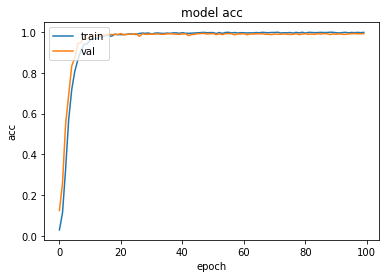

In [44]:
# PLOTTING ACCURACY

plt.plot(cnn_hist.history['acc'])
plt.plot(cnn_hist.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('final_acc.png', bbox_inches='tight')
plt.show()

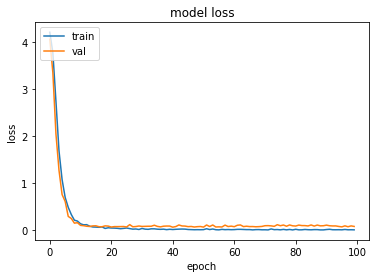

In [45]:
# PLOTTING LOSS

plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('final_loss.png', bbox_inches='tight')
plt.show()

In [46]:
# PREPARING TESTING DATA

testing_list = testing_list.astype('float32')/255.

lb = LabelEncoder()
testing_label = np_utils.to_categorical(lb.fit_transform(testing_label.ravel()))                                    

In [47]:
# EVALUATING THE MODEL

result = cnn_model.evaluate(testing_list, testing_label, verbose=0)
print ("%s: %.2f%%" % (cnn_model.metrics_names[1], result[1]*100))

acc: 43.70%


In [48]:
# SAVING THE MODEL

model_name = 'final_model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)
cnn_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_json = cnn_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Saved trained model at C:\Users\CASALAB\Desktop\CNN - FaceRecognition\saved_models\final_model.h5 


In [49]:
# PREDICTING WITHOUT LABELS AND SAVING TO .CSV FILE

preds = cnn_model.predict(testing_list, batch_size=32, verbose=1)

max_percentage_predictions = preds.argmax(axis=1)
flatten_predictions = max_percentage_predictions.astype(int).flatten()

predictions = (lb.inverse_transform((flatten_predictions)))
predictions_df = pd.DataFrame({'predictedvalues': predictions})

true_values = testing_label.argmax(axis=1)
flatten_true_values = true_values.astype(int).flatten()

true_values = (lb.inverse_transform((flatten_true_values)))
true_values_df = pd.DataFrame({'actualvalues': true_values})

predictions_and_truevalues = true_values_df.join(predictions_df)
predictions_and_truevalues.to_csv('Predictions.csv', index=False)

3593/3593 [==============================] - 29s 8ms/step


## Prediction Module

In [2]:
# loading json and creating model

import numpy
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
#load weights into new model
loaded_model.load_weights("saved_models/final_modelA.h5")
print("Loaded model from disk")
 
#evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])








Loaded model from disk




Loaded file: C:/Users/nazir/Desktop/CNN - FaceRecognition/DB/1/mode_1_frame_7_face_1.png


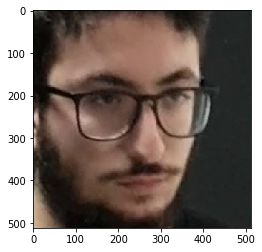

In [4]:
from tkinter import filedialog
from tkinter import *
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

root = Tk()
file = filedialog.askopenfile()
root.destroy()

print("Loaded file: " + file.name)
plt.imshow(mpimg.imread(file.name))

In [73]:
#import cv2
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

#filename = "DB/48/mode_1_frame_13_face_0.png"
#file = open(filename)
#print("Loaded file: " + file.name)
#plt.imshow(mpimg.imread(filename))

In [74]:
if(cv2.imread(file.name).size == 786432):
    img = cv2.imread(file.name)
    small = cv2.resize(img, (0,0), fx=0.2, fy=0.2)

In [75]:
# Creating feature vector
import numpy as np

prediction = []
prediction.append(small)
x = np.array(prediction)

In [76]:
# Normalizing feature vector
to_predict = x.astype('float32')/255.

In [77]:
# Using the already trained model to predict
livepreds = loaded_model.predict(to_predict, 
                         batch_size=16, 
                         verbose=2)

In [78]:
subjects = livepreds.argsort().ravel()[-5:][::-1]
real_subjects = subjects+1

i = 0
for subject in subjects:
    print(str(real_subjects[i]) + ": " + str(round(livepreds.ravel()[subject]*100, 2)) + "%")
    i += 1

1: 95.4%
17: 4.6%
42: 0.0%
54: 0.0%
13: 0.0%
